# Model Performance Test


In [1]:
from dtsp.dataset import walk_forward_split, Seq2SeqDataSet, SimpleSeq2SeqDataSet, SimpleWaveNetDataSet
from dtsp.models import Seq2Seq, SimpleSeq2Seq, SimpleWaveNet
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pathlib import Path
import shutil
import seaborn as sns

%matplotlib inline

def plot_attentions(attns):
    if attns.ndim == 4:
        assert attns.shape[0] == 1
        attns = attns.squeeze(0)
    if isinstance(attns, torch.Tensor):
        attns = attns.detach().numpy()
    n_head = attns.shape[1]
    
    base_size = 12
    
    hight = attns.shape[0]
    wide = attns.shape[2]
    for i in range(n_head):
        plt.figure(figsize=(16, hight / wide * 16))
        sns.heatmap(attns[:, i, :])
        plt.title(f"Attention {i}")
        plt.xlabel('history')
        plt.ylabel('prediction')


def plot_prediction(enc, y_pred, y_true):
    f = plt.figure(figsize=(12, 4))
    enc_lens = len(enc)
    dec_lens = len(y_pred)
    plt.plot(enc)
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_pred, label='prediction', linestyle='--')
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_true, label='true')
    plt.legend()

In [2]:
torch.__version__

'1.3.0'

## 1. prepare dataset

In [3]:
df = pd.read_csv('./data.csv', index_col='date_time', parse_dates=['date_time'])
series = df.values
month = df.index.month.values
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
date_time,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0


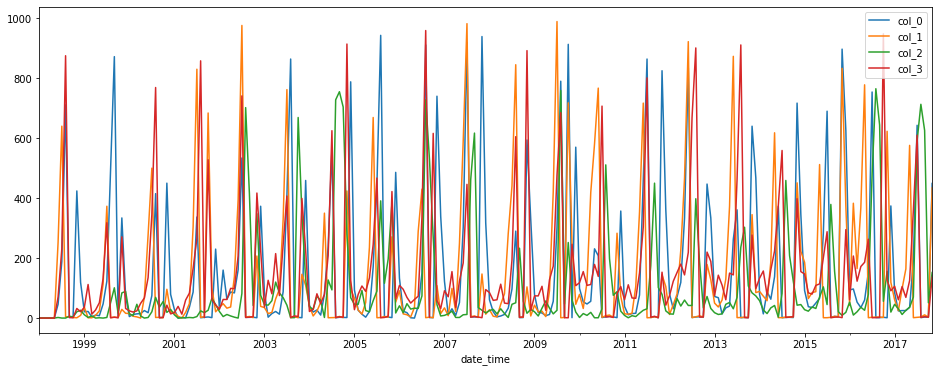

In [4]:
df.iloc[:, :4].plot(figsize=(16, 6))

**Target**

In [5]:
n_test = 12
n_val = 12
enc_lens = 72
dec_lens = 12
batch_size = 8
epochs = 50

## 1. Simple Seq2Seq Model

In [23]:
dataset = SimpleSeq2SeqDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [24]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.2,
        'hidden_size': 72,
        'teacher_forcing_rate': 0.5,
        'learning_rate': 0.001,
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = SimpleSeq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.980: 100%|██████████| 17/17 [00:00<00:00, 20.79it/s]


epoch 1 / 50: train loss 1.050 val loss 1.190 RMSE 181.258
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.845: 100%|██████████| 17/17 [00:00<00:00, 19.15it/s]


epoch 2 / 50: train loss 0.942 val loss 0.993 RMSE 169.968


batch 17 / 17, loss 0.820: 100%|██████████| 17/17 [00:00<00:00, 20.08it/s]


epoch 3 / 50: train loss 0.820 val loss 0.960 RMSE 166.055


batch 17 / 17, loss 0.932: 100%|██████████| 17/17 [00:00<00:00, 20.49it/s]


epoch 4 / 50: train loss 0.808 val loss 0.937 RMSE 164.511


batch 17 / 17, loss 0.809: 100%|██████████| 17/17 [00:00<00:00, 20.86it/s]


epoch 5 / 50: train loss 0.787 val loss 0.935 RMSE 164.318


batch 17 / 17, loss 0.934: 100%|██████████| 17/17 [00:00<00:00, 18.96it/s]


epoch 6 / 50: train loss 0.777 val loss 0.935 RMSE 162.984


batch 17 / 17, loss 0.650: 100%|██████████| 17/17 [00:00<00:00, 20.20it/s]


epoch 7 / 50: train loss 0.732 val loss 0.859 RMSE 155.444


batch 17 / 17, loss 0.680: 100%|██████████| 17/17 [00:00<00:00, 19.77it/s]


epoch 8 / 50: train loss 0.696 val loss 0.848 RMSE 154.758


batch 17 / 17, loss 0.570: 100%|██████████| 17/17 [00:00<00:00, 20.61it/s]


epoch 9 / 50: train loss 0.670 val loss 0.837 RMSE 153.705


batch 17 / 17, loss 0.589: 100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 10 / 50: train loss 0.680 val loss 0.849 RMSE 155.316


batch 17 / 17, loss 0.677: 100%|██████████| 17/17 [00:00<00:00, 19.82it/s]


epoch 11 / 50: train loss 0.650 val loss 0.808 RMSE 150.322


batch 17 / 17, loss 0.681: 100%|██████████| 17/17 [00:00<00:00, 19.33it/s]


epoch 12 / 50: train loss 0.634 val loss 0.817 RMSE 150.648


batch 17 / 17, loss 0.623: 100%|██████████| 17/17 [00:00<00:00, 18.79it/s]


epoch 13 / 50: train loss 0.649 val loss 0.870 RMSE 155.498


batch 17 / 17, loss 0.733: 100%|██████████| 17/17 [00:00<00:00, 17.50it/s]


epoch 14 / 50: train loss 0.643 val loss 0.787 RMSE 147.421


batch 17 / 17, loss 0.615: 100%|██████████| 17/17 [00:00<00:00, 18.45it/s]


epoch 15 / 50: train loss 0.609 val loss 0.778 RMSE 146.388


batch 17 / 17, loss 0.590: 100%|██████████| 17/17 [00:00<00:00, 19.98it/s]


epoch 16 / 50: train loss 0.595 val loss 0.775 RMSE 145.835


batch 17 / 17, loss 0.689: 100%|██████████| 17/17 [00:00<00:00, 20.10it/s]


epoch 17 / 50: train loss 0.577 val loss 0.762 RMSE 144.709


batch 17 / 17, loss 0.586: 100%|██████████| 17/17 [00:00<00:00, 20.03it/s]


epoch 18 / 50: train loss 0.573 val loss 0.813 RMSE 150.661


batch 17 / 17, loss 0.630: 100%|██████████| 17/17 [00:00<00:00, 20.03it/s]


epoch 19 / 50: train loss 0.565 val loss 0.797 RMSE 149.152


batch 17 / 17, loss 0.585: 100%|██████████| 17/17 [00:00<00:00, 20.17it/s]


epoch 20 / 50: train loss 0.555 val loss 0.755 RMSE 144.340


batch 17 / 17, loss 0.492: 100%|██████████| 17/17 [00:00<00:00, 20.62it/s]


epoch 21 / 50: train loss 0.529 val loss 0.740 RMSE 142.812


batch 17 / 17, loss 0.494: 100%|██████████| 17/17 [00:00<00:00, 20.20it/s]


epoch 22 / 50: train loss 0.526 val loss 0.736 RMSE 142.389


batch 17 / 17, loss 0.501: 100%|██████████| 17/17 [00:00<00:00, 20.39it/s]


epoch 23 / 50: train loss 0.518 val loss 0.722 RMSE 141.230


batch 17 / 17, loss 0.559: 100%|██████████| 17/17 [00:00<00:00, 19.82it/s]


epoch 24 / 50: train loss 0.532 val loss 0.743 RMSE 143.153


batch 17 / 17, loss 0.401: 100%|██████████| 17/17 [00:00<00:00, 19.46it/s]


epoch 25 / 50: train loss 0.534 val loss 0.721 RMSE 140.465


batch 17 / 17, loss 0.495: 100%|██████████| 17/17 [00:00<00:00, 19.50it/s]


epoch 26 / 50: train loss 0.524 val loss 0.723 RMSE 141.711


batch 17 / 17, loss 0.505: 100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 27 / 50: train loss 0.502 val loss 0.712 RMSE 140.106


batch 17 / 17, loss 0.414: 100%|██████████| 17/17 [00:00<00:00, 20.37it/s]


epoch 28 / 50: train loss 0.480 val loss 0.701 RMSE 138.778


batch 17 / 17, loss 0.557: 100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 29 / 50: train loss 0.478 val loss 0.697 RMSE 137.952


batch 17 / 17, loss 0.461: 100%|██████████| 17/17 [00:00<00:00, 20.74it/s]


epoch 30 / 50: train loss 0.463 val loss 0.707 RMSE 139.788


batch 17 / 17, loss 0.436: 100%|██████████| 17/17 [00:00<00:00, 19.41it/s]


epoch 31 / 50: train loss 0.478 val loss 0.690 RMSE 137.459


batch 17 / 17, loss 0.420: 100%|██████████| 17/17 [00:00<00:00, 20.28it/s]


epoch 32 / 50: train loss 0.468 val loss 0.682 RMSE 136.453


batch 17 / 17, loss 0.590: 100%|██████████| 17/17 [00:00<00:00, 19.84it/s]


epoch 33 / 50: train loss 0.466 val loss 0.679 RMSE 136.305


batch 17 / 17, loss 0.598: 100%|██████████| 17/17 [00:00<00:00, 20.15it/s]


epoch 34 / 50: train loss 0.469 val loss 0.669 RMSE 134.382


batch 17 / 17, loss 0.397: 100%|██████████| 17/17 [00:00<00:00, 20.46it/s]


epoch 35 / 50: train loss 0.451 val loss 0.676 RMSE 136.107


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 36 / 50: train loss 0.451 val loss 0.668 RMSE 134.664


batch 17 / 17, loss 0.442: 100%|██████████| 17/17 [00:00<00:00, 19.87it/s]


epoch 37 / 50: train loss 0.442 val loss 0.669 RMSE 134.555


batch 17 / 17, loss 0.480: 100%|██████████| 17/17 [00:00<00:00, 19.20it/s]


epoch 38 / 50: train loss 0.460 val loss 0.664 RMSE 134.004


batch 17 / 17, loss 0.441: 100%|██████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 39 / 50: train loss 0.438 val loss 0.657 RMSE 133.175


batch 17 / 17, loss 0.391: 100%|██████████| 17/17 [00:00<00:00, 19.50it/s]


epoch 40 / 50: train loss 0.451 val loss 0.660 RMSE 134.015


batch 17 / 17, loss 0.400: 100%|██████████| 17/17 [00:00<00:00, 19.39it/s]


epoch 41 / 50: train loss 0.448 val loss 0.657 RMSE 133.291


batch 17 / 17, loss 0.354: 100%|██████████| 17/17 [00:00<00:00, 19.87it/s]


epoch 42 / 50: train loss 0.439 val loss 0.655 RMSE 132.930


batch 17 / 17, loss 0.507: 100%|██████████| 17/17 [00:00<00:00, 20.74it/s]


epoch 43 / 50: train loss 0.429 val loss 0.655 RMSE 132.799


batch 17 / 17, loss 0.441: 100%|██████████| 17/17 [00:00<00:00, 19.39it/s]


epoch 44 / 50: train loss 0.440 val loss 0.650 RMSE 132.645


batch 17 / 17, loss 0.421: 100%|██████████| 17/17 [00:00<00:00, 19.89it/s]


epoch 45 / 50: train loss 0.438 val loss 0.648 RMSE 132.160


batch 17 / 17, loss 0.364: 100%|██████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 46 / 50: train loss 0.420 val loss 0.646 RMSE 131.892


batch 17 / 17, loss 0.444: 100%|██████████| 17/17 [00:00<00:00, 20.41it/s]


epoch 47 / 50: train loss 0.419 val loss 0.645 RMSE 131.806


batch 17 / 17, loss 0.480: 100%|██████████| 17/17 [00:00<00:00, 20.13it/s]


epoch 48 / 50: train loss 0.430 val loss 0.645 RMSE 131.835


batch 17 / 17, loss 0.417: 100%|██████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 49 / 50: train loss 0.416 val loss 0.644 RMSE 131.699


batch 17 / 17, loss 0.455: 100%|██████████| 17/17 [00:00<00:00, 20.13it/s]


epoch 50 / 50: train loss 0.431 val loss 0.645 RMSE 131.917
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleSeq2Seq_epoch_49_0.644.pkl


In [25]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.447, valid loss: 0.644, test loss :0.699, test RMSE :137.596, 


Text(0.5, 1.0, 'Simple Seq2Seq prediction')

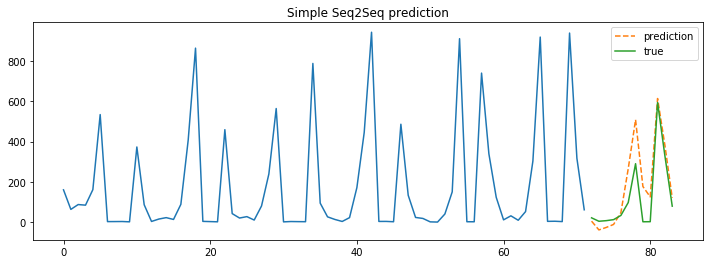

In [26]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Simple Seq2Seq prediction')

## 2. Seq2Seq(Attention 0)

In [27]:
dataset = Seq2SeqDataSet(series, enc_lens, dec_lens, categorical_var=month)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [28]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': False,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 1.010: 100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


epoch 1 / 50: train loss 1.014 val loss 1.054 RMSE 172.341
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.716: 100%|██████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 2 / 50: train loss 0.826 val loss 0.964 RMSE 166.241


batch 17 / 17, loss 0.668: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 3 / 50: train loss 0.753 val loss 0.940 RMSE 163.817


batch 17 / 17, loss 0.687: 100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 4 / 50: train loss 0.760 val loss 0.886 RMSE 158.871


batch 17 / 17, loss 0.723: 100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


epoch 5 / 50: train loss 0.717 val loss 0.870 RMSE 157.213


batch 17 / 17, loss 0.695: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 6 / 50: train loss 0.695 val loss 0.845 RMSE 154.281


batch 17 / 17, loss 0.838: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 7 / 50: train loss 0.678 val loss 0.882 RMSE 158.370


batch 17 / 17, loss 0.969: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 8 / 50: train loss 0.733 val loss 0.923 RMSE 160.644


batch 17 / 17, loss 0.736: 100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


epoch 9 / 50: train loss 0.662 val loss 0.799 RMSE 148.252


batch 17 / 17, loss 0.485: 100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


epoch 10 / 50: train loss 0.600 val loss 0.800 RMSE 149.014


batch 17 / 17, loss 0.622: 100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


epoch 11 / 50: train loss 0.585 val loss 0.775 RMSE 146.613


batch 17 / 17, loss 0.600: 100%|██████████| 17/17 [00:02<00:00,  8.18it/s]


epoch 12 / 50: train loss 0.583 val loss 0.762 RMSE 145.436


batch 17 / 17, loss 0.645: 100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


epoch 13 / 50: train loss 0.562 val loss 0.759 RMSE 144.921


batch 17 / 17, loss 0.436: 100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 14 / 50: train loss 0.551 val loss 0.762 RMSE 146.413


batch 17 / 17, loss 0.449: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 15 / 50: train loss 0.538 val loss 0.780 RMSE 148.313


batch 17 / 17, loss 0.541: 100%|██████████| 17/17 [00:02<00:00,  7.71it/s]


epoch 16 / 50: train loss 0.522 val loss 0.734 RMSE 142.245


batch 17 / 17, loss 0.624: 100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


epoch 17 / 50: train loss 0.499 val loss 0.788 RMSE 149.728


batch 17 / 17, loss 0.597: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


epoch 18 / 50: train loss 0.533 val loss 0.744 RMSE 142.986


batch 17 / 17, loss 0.501: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 19 / 50: train loss 0.517 val loss 0.743 RMSE 143.799


batch 17 / 17, loss 0.421: 100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 20 / 50: train loss 0.512 val loss 0.740 RMSE 142.593


batch 17 / 17, loss 0.578: 100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


epoch 21 / 50: train loss 0.484 val loss 0.772 RMSE 147.216


batch 17 / 17, loss 0.413: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 22 / 50: train loss 0.487 val loss 0.789 RMSE 147.903


batch 17 / 17, loss 0.473: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 23 / 50: train loss 0.540 val loss 0.722 RMSE 140.129


batch 17 / 17, loss 0.386: 100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


epoch 24 / 50: train loss 0.457 val loss 0.679 RMSE 137.710


batch 17 / 17, loss 0.379: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 25 / 50: train loss 0.420 val loss 0.661 RMSE 134.924


batch 17 / 17, loss 0.334: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 26 / 50: train loss 0.415 val loss 0.655 RMSE 134.043


batch 17 / 17, loss 0.316: 100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 27 / 50: train loss 0.385 val loss 0.641 RMSE 133.114


batch 17 / 17, loss 0.354: 100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


epoch 28 / 50: train loss 0.386 val loss 0.616 RMSE 129.842


batch 17 / 17, loss 0.481: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 29 / 50: train loss 0.372 val loss 0.606 RMSE 128.816


batch 17 / 17, loss 0.363: 100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


epoch 30 / 50: train loss 0.384 val loss 0.605 RMSE 127.765


batch 17 / 17, loss 0.301: 100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


epoch 31 / 50: train loss 0.365 val loss 0.603 RMSE 127.791


batch 17 / 17, loss 0.279: 100%|██████████| 17/17 [00:02<00:00,  8.17it/s]


epoch 32 / 50: train loss 0.352 val loss 0.590 RMSE 127.120


batch 17 / 17, loss 0.344: 100%|██████████| 17/17 [00:02<00:00,  8.06it/s]


epoch 33 / 50: train loss 0.367 val loss 0.576 RMSE 124.221


batch 17 / 17, loss 0.357: 100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 34 / 50: train loss 0.348 val loss 0.564 RMSE 123.273


batch 17 / 17, loss 0.356: 100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


epoch 35 / 50: train loss 0.332 val loss 0.568 RMSE 124.158


batch 17 / 17, loss 0.279: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 36 / 50: train loss 0.331 val loss 0.561 RMSE 122.395


batch 17 / 17, loss 0.338: 100%|██████████| 17/17 [00:02<00:00,  8.24it/s]


epoch 37 / 50: train loss 0.315 val loss 0.552 RMSE 121.291


batch 17 / 17, loss 0.391: 100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


epoch 38 / 50: train loss 0.318 val loss 0.546 RMSE 120.088


batch 17 / 17, loss 0.406: 100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 39 / 50: train loss 0.317 val loss 0.541 RMSE 118.752


batch 17 / 17, loss 0.269: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


epoch 40 / 50: train loss 0.306 val loss 0.533 RMSE 117.964


batch 17 / 17, loss 0.269: 100%|██████████| 17/17 [00:02<00:00,  7.82it/s]


epoch 41 / 50: train loss 0.319 val loss 0.529 RMSE 117.673


batch 17 / 17, loss 0.274: 100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


epoch 42 / 50: train loss 0.299 val loss 0.524 RMSE 116.510


batch 17 / 17, loss 0.275: 100%|██████████| 17/17 [00:02<00:00,  8.17it/s]


epoch 43 / 50: train loss 0.291 val loss 0.524 RMSE 116.751


batch 17 / 17, loss 0.357: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 44 / 50: train loss 0.299 val loss 0.517 RMSE 115.801


batch 17 / 17, loss 0.260: 100%|██████████| 17/17 [00:02<00:00,  8.33it/s]


epoch 45 / 50: train loss 0.276 val loss 0.520 RMSE 116.319


batch 17 / 17, loss 0.561: 100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


epoch 46 / 50: train loss 0.315 val loss 0.516 RMSE 115.404


batch 17 / 17, loss 0.219: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 47 / 50: train loss 0.292 val loss 0.514 RMSE 115.454


batch 17 / 17, loss 0.273: 100%|██████████| 17/17 [00:02<00:00,  8.32it/s]


epoch 48 / 50: train loss 0.278 val loss 0.513 RMSE 115.268


batch 17 / 17, loss 0.309: 100%|██████████| 17/17 [00:02<00:00,  8.20it/s]


epoch 49 / 50: train loss 0.292 val loss 0.512 RMSE 115.185


batch 17 / 17, loss 0.242: 100%|██████████| 17/17 [00:02<00:00,  8.30it/s]


epoch 50 / 50: train loss 0.285 val loss 0.512 RMSE 115.072
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_50_0.512.pkl


In [29]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.304, valid loss: 0.512, test loss :0.581, test RMSE :123.280, 


Text(0.5, 1.0, 'Seq2Seq 0 Attention prediction')

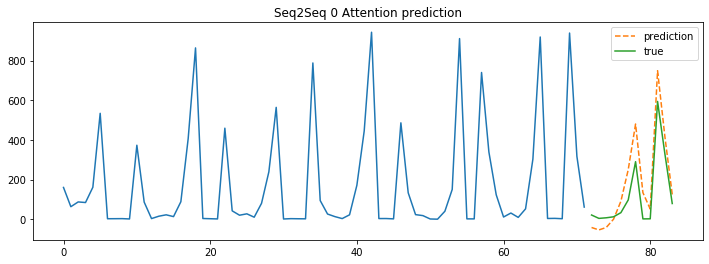

In [30]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 0 Attention prediction')

## 3. Seq2Seq(Attention 1)

In [31]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 1,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 1.022: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 1 / 50: train loss 1.071 val loss 1.180 RMSE 180.460
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.888: 100%|██████████| 17/17 [00:02<00:00,  7.69it/s]


epoch 2 / 50: train loss 0.926 val loss 0.962 RMSE 166.658


batch 17 / 17, loss 0.812: 100%|██████████| 17/17 [00:02<00:00,  7.50it/s]


epoch 3 / 50: train loss 0.832 val loss 0.934 RMSE 164.780


batch 17 / 17, loss 1.082: 100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


epoch 4 / 50: train loss 0.804 val loss 0.914 RMSE 163.136


batch 17 / 17, loss 0.615: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 5 / 50: train loss 0.775 val loss 0.912 RMSE 162.801


batch 17 / 17, loss 0.666: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 6 / 50: train loss 0.721 val loss 0.848 RMSE 155.015


batch 17 / 17, loss 0.716: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


epoch 7 / 50: train loss 0.697 val loss 0.814 RMSE 151.236


batch 17 / 17, loss 0.589: 100%|██████████| 17/17 [00:02<00:00,  7.67it/s]


epoch 8 / 50: train loss 0.664 val loss 0.795 RMSE 148.914


batch 17 / 17, loss 0.606: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


epoch 9 / 50: train loss 0.629 val loss 0.812 RMSE 153.360


batch 17 / 17, loss 0.934: 100%|██████████| 17/17 [00:02<00:00,  7.66it/s]


epoch 10 / 50: train loss 0.649 val loss 0.923 RMSE 161.343


batch 17 / 17, loss 0.701: 100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 11 / 50: train loss 0.625 val loss 0.753 RMSE 146.265


batch 17 / 17, loss 0.447: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 12 / 50: train loss 0.558 val loss 0.756 RMSE 147.058


batch 17 / 17, loss 0.575: 100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 13 / 50: train loss 0.527 val loss 0.717 RMSE 142.573


batch 17 / 17, loss 0.648: 100%|██████████| 17/17 [00:02<00:00,  7.63it/s]


epoch 14 / 50: train loss 0.534 val loss 0.731 RMSE 143.565


batch 17 / 17, loss 0.489: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


epoch 15 / 50: train loss 0.500 val loss 0.704 RMSE 141.850


batch 17 / 17, loss 0.516: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


epoch 16 / 50: train loss 0.495 val loss 0.698 RMSE 139.742


batch 17 / 17, loss 0.406: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 17 / 50: train loss 0.454 val loss 0.672 RMSE 137.975


batch 17 / 17, loss 0.432: 100%|██████████| 17/17 [00:02<00:00,  7.63it/s]


epoch 18 / 50: train loss 0.464 val loss 0.683 RMSE 139.270


batch 17 / 17, loss 0.452: 100%|██████████| 17/17 [00:02<00:00,  7.62it/s]


epoch 19 / 50: train loss 0.453 val loss 0.651 RMSE 134.476


batch 17 / 17, loss 0.445: 100%|██████████| 17/17 [00:02<00:00,  7.57it/s]


epoch 20 / 50: train loss 0.436 val loss 0.627 RMSE 131.236


batch 17 / 17, loss 0.371: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


epoch 21 / 50: train loss 0.418 val loss 0.615 RMSE 129.996


batch 17 / 17, loss 0.387: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


epoch 22 / 50: train loss 0.390 val loss 0.641 RMSE 133.563


batch 17 / 17, loss 0.424: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 23 / 50: train loss 0.389 val loss 0.598 RMSE 127.480


batch 17 / 17, loss 0.307: 100%|██████████| 17/17 [00:02<00:00,  7.77it/s]


epoch 24 / 50: train loss 0.377 val loss 0.616 RMSE 131.270


batch 17 / 17, loss 0.300: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 25 / 50: train loss 0.368 val loss 0.594 RMSE 126.970


batch 17 / 17, loss 0.309: 100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


epoch 26 / 50: train loss 0.351 val loss 0.574 RMSE 124.678


batch 17 / 17, loss 0.278: 100%|██████████| 17/17 [00:02<00:00,  7.55it/s]


epoch 27 / 50: train loss 0.348 val loss 0.549 RMSE 120.690


batch 17 / 17, loss 0.268: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 28 / 50: train loss 0.314 val loss 0.538 RMSE 118.496


batch 17 / 17, loss 0.236: 100%|██████████| 17/17 [00:02<00:00,  7.71it/s]


epoch 29 / 50: train loss 0.304 val loss 0.527 RMSE 116.852


batch 17 / 17, loss 0.493: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 30 / 50: train loss 0.289 val loss 0.530 RMSE 117.525


batch 17 / 17, loss 0.271: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 31 / 50: train loss 0.277 val loss 0.510 RMSE 115.592


batch 17 / 17, loss 0.280: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 32 / 50: train loss 0.280 val loss 0.503 RMSE 113.498


batch 17 / 17, loss 0.377: 100%|██████████| 17/17 [00:02<00:00,  7.77it/s]


epoch 33 / 50: train loss 0.278 val loss 0.495 RMSE 112.230


batch 17 / 17, loss 0.224: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


epoch 34 / 50: train loss 0.253 val loss 0.500 RMSE 112.719


batch 17 / 17, loss 0.267: 100%|██████████| 17/17 [00:02<00:00,  7.73it/s]


epoch 35 / 50: train loss 0.263 val loss 0.490 RMSE 111.273


batch 17 / 17, loss 0.377: 100%|██████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 36 / 50: train loss 0.265 val loss 0.489 RMSE 110.463


batch 17 / 17, loss 0.201: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


epoch 37 / 50: train loss 0.241 val loss 0.475 RMSE 107.977


batch 17 / 17, loss 0.389: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


epoch 38 / 50: train loss 0.249 val loss 0.468 RMSE 107.361


batch 17 / 17, loss 0.188: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 39 / 50: train loss 0.231 val loss 0.461 RMSE 106.357


batch 17 / 17, loss 0.333: 100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 40 / 50: train loss 0.232 val loss 0.460 RMSE 105.398


batch 17 / 17, loss 0.199: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


epoch 41 / 50: train loss 0.225 val loss 0.462 RMSE 105.580


batch 17 / 17, loss 0.424: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 42 / 50: train loss 0.225 val loss 0.452 RMSE 104.065


batch 17 / 17, loss 0.183: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 43 / 50: train loss 0.212 val loss 0.455 RMSE 104.712


batch 17 / 17, loss 0.222: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


epoch 44 / 50: train loss 0.212 val loss 0.448 RMSE 103.758


batch 17 / 17, loss 0.176: 100%|██████████| 17/17 [00:02<00:00,  7.69it/s]


epoch 45 / 50: train loss 0.219 val loss 0.445 RMSE 102.928


batch 17 / 17, loss 0.201: 100%|██████████| 17/17 [00:02<00:00,  7.59it/s]


epoch 46 / 50: train loss 0.217 val loss 0.442 RMSE 102.556


batch 17 / 17, loss 0.235: 100%|██████████| 17/17 [00:02<00:00,  7.82it/s]


epoch 47 / 50: train loss 0.213 val loss 0.441 RMSE 102.279


batch 17 / 17, loss 0.217: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


epoch 48 / 50: train loss 0.215 val loss 0.439 RMSE 101.933


batch 17 / 17, loss 0.178: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 49 / 50: train loss 0.208 val loss 0.437 RMSE 101.674


batch 17 / 17, loss 0.166: 100%|██████████| 17/17 [00:02<00:00,  7.47it/s]


epoch 50 / 50: train loss 0.210 val loss 0.439 RMSE 101.907
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_49_0.437.pkl


In [32]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.217, valid loss: 0.437, test loss :0.534, test RMSE :114.353, 


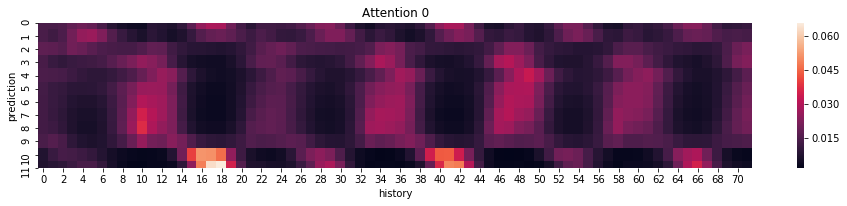

In [33]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 1 Attention prediction')

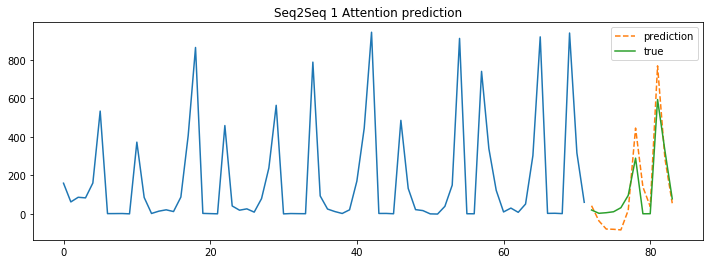

In [34]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 1 Attention prediction')

## 4. Seq2Seq(Attention 4)

In [35]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 1.068: 100%|██████████| 17/17 [00:02<00:00,  6.69it/s]


epoch 1 / 50: train loss 1.062 val loss 1.142 RMSE 177.985
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 1.184: 100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


epoch 2 / 50: train loss 0.895 val loss 0.971 RMSE 167.102


batch 17 / 17, loss 0.877: 100%|██████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 3 / 50: train loss 0.809 val loss 0.936 RMSE 165.054


batch 17 / 17, loss 0.963: 100%|██████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 4 / 50: train loss 0.790 val loss 0.910 RMSE 162.712


batch 17 / 17, loss 0.734: 100%|██████████| 17/17 [00:02<00:00,  7.33it/s]


epoch 5 / 50: train loss 0.756 val loss 0.906 RMSE 162.288


batch 17 / 17, loss 0.713: 100%|██████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 6 / 50: train loss 0.741 val loss 0.830 RMSE 153.789


batch 17 / 17, loss 0.711: 100%|██████████| 17/17 [00:02<00:00,  6.96it/s]


epoch 7 / 50: train loss 0.682 val loss 0.811 RMSE 151.363


batch 17 / 17, loss 0.625: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]


epoch 8 / 50: train loss 0.654 val loss 0.966 RMSE 168.212


batch 17 / 17, loss 0.613: 100%|██████████| 17/17 [00:02<00:00,  6.91it/s]


epoch 9 / 50: train loss 0.667 val loss 0.949 RMSE 165.675


batch 17 / 17, loss 0.776: 100%|██████████| 17/17 [00:02<00:00,  6.96it/s]


epoch 10 / 50: train loss 0.692 val loss 0.839 RMSE 154.460


batch 17 / 17, loss 0.594: 100%|██████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 11 / 50: train loss 0.641 val loss 0.878 RMSE 159.045


batch 17 / 17, loss 0.577: 100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


epoch 12 / 50: train loss 0.623 val loss 0.772 RMSE 147.450


batch 17 / 17, loss 0.548: 100%|██████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 13 / 50: train loss 0.562 val loss 0.739 RMSE 144.357


batch 17 / 17, loss 0.513: 100%|██████████| 17/17 [00:02<00:00,  7.04it/s]


epoch 14 / 50: train loss 0.542 val loss 0.710 RMSE 141.956


batch 17 / 17, loss 0.540: 100%|██████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 15 / 50: train loss 0.529 val loss 0.719 RMSE 143.806


batch 17 / 17, loss 0.424: 100%|██████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 16 / 50: train loss 0.511 val loss 0.723 RMSE 144.894


batch 17 / 17, loss 0.479: 100%|██████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 17 / 50: train loss 0.533 val loss 0.733 RMSE 143.083


batch 17 / 17, loss 0.455: 100%|██████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 18 / 50: train loss 0.509 val loss 0.682 RMSE 139.506


batch 17 / 17, loss 0.479: 100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


epoch 19 / 50: train loss 0.482 val loss 0.700 RMSE 142.026


batch 17 / 17, loss 0.700: 100%|██████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 20 / 50: train loss 0.462 val loss 0.647 RMSE 134.651


batch 17 / 17, loss 0.491: 100%|██████████| 17/17 [00:02<00:00,  6.31it/s]


epoch 21 / 50: train loss 0.460 val loss 0.631 RMSE 132.361


batch 17 / 17, loss 0.370: 100%|██████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 22 / 50: train loss 0.420 val loss 0.631 RMSE 133.009


batch 17 / 17, loss 0.380: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 23 / 50: train loss 0.400 val loss 0.628 RMSE 132.901


batch 17 / 17, loss 0.384: 100%|██████████| 17/17 [00:02<00:00,  6.65it/s]


epoch 24 / 50: train loss 0.415 val loss 0.622 RMSE 130.647


batch 17 / 17, loss 0.438: 100%|██████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 25 / 50: train loss 0.396 val loss 0.609 RMSE 131.143


batch 17 / 17, loss 0.302: 100%|██████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 26 / 50: train loss 0.362 val loss 0.584 RMSE 127.463


batch 17 / 17, loss 0.361: 100%|██████████| 17/17 [00:02<00:00,  7.23it/s]


epoch 27 / 50: train loss 0.346 val loss 0.568 RMSE 126.145


batch 17 / 17, loss 0.334: 100%|██████████| 17/17 [00:02<00:00,  7.04it/s]


epoch 28 / 50: train loss 0.339 val loss 0.556 RMSE 123.711


batch 17 / 17, loss 0.340: 100%|██████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 29 / 50: train loss 0.320 val loss 0.544 RMSE 121.331


batch 17 / 17, loss 0.288: 100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


epoch 30 / 50: train loss 0.325 val loss 0.531 RMSE 118.848


batch 17 / 17, loss 0.335: 100%|██████████| 17/17 [00:02<00:00,  7.12it/s]


epoch 31 / 50: train loss 0.297 val loss 0.517 RMSE 117.041


batch 17 / 17, loss 0.273: 100%|██████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 32 / 50: train loss 0.290 val loss 0.515 RMSE 116.238


batch 17 / 17, loss 0.248: 100%|██████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 33 / 50: train loss 0.288 val loss 0.499 RMSE 113.968


batch 17 / 17, loss 0.272: 100%|██████████| 17/17 [00:02<00:00,  7.12it/s]


epoch 34 / 50: train loss 0.270 val loss 0.488 RMSE 112.634


batch 17 / 17, loss 0.207: 100%|██████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 35 / 50: train loss 0.259 val loss 0.489 RMSE 112.317


batch 17 / 17, loss 0.316: 100%|██████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 36 / 50: train loss 0.265 val loss 0.485 RMSE 110.528


batch 17 / 17, loss 0.309: 100%|██████████| 17/17 [00:02<00:00,  6.69it/s]


epoch 37 / 50: train loss 0.269 val loss 0.472 RMSE 109.207


batch 17 / 17, loss 0.511: 100%|██████████| 17/17 [00:02<00:00,  6.72it/s]


epoch 38 / 50: train loss 0.263 val loss 0.464 RMSE 107.653


batch 17 / 17, loss 0.267: 100%|██████████| 17/17 [00:02<00:00,  6.37it/s]


epoch 39 / 50: train loss 0.254 val loss 0.449 RMSE 105.845


batch 17 / 17, loss 0.229: 100%|██████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 40 / 50: train loss 0.240 val loss 0.443 RMSE 105.424


batch 17 / 17, loss 0.227: 100%|██████████| 17/17 [00:02<00:00,  7.19it/s]


epoch 41 / 50: train loss 0.231 val loss 0.445 RMSE 104.981


batch 17 / 17, loss 0.172: 100%|██████████| 17/17 [00:02<00:00,  7.12it/s]


epoch 42 / 50: train loss 0.225 val loss 0.445 RMSE 104.837


batch 17 / 17, loss 0.226: 100%|██████████| 17/17 [00:02<00:00,  6.81it/s]


epoch 43 / 50: train loss 0.229 val loss 0.439 RMSE 103.909


batch 17 / 17, loss 0.204: 100%|██████████| 17/17 [00:02<00:00,  7.12it/s]


epoch 44 / 50: train loss 0.218 val loss 0.436 RMSE 103.072


batch 17 / 17, loss 0.208: 100%|██████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 45 / 50: train loss 0.224 val loss 0.438 RMSE 103.400


batch 17 / 17, loss 0.273: 100%|██████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 46 / 50: train loss 0.217 val loss 0.430 RMSE 102.343


batch 17 / 17, loss 0.188: 100%|██████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 47 / 50: train loss 0.217 val loss 0.431 RMSE 102.170


batch 17 / 17, loss 0.282: 100%|██████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 48 / 50: train loss 0.218 val loss 0.431 RMSE 102.097


batch 17 / 17, loss 0.177: 100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 49 / 50: train loss 0.212 val loss 0.429 RMSE 101.878


batch 17 / 17, loss 0.215: 100%|██████████| 17/17 [00:02<00:00,  6.90it/s]


epoch 50 / 50: train loss 0.211 val loss 0.428 RMSE 101.544
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_50_0.428.pkl


In [36]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.214, valid loss: 0.428, test loss :0.548, test RMSE :115.235, 


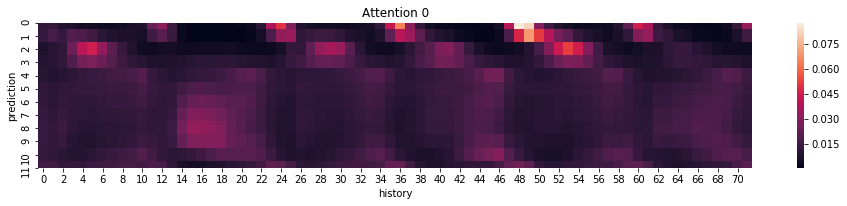

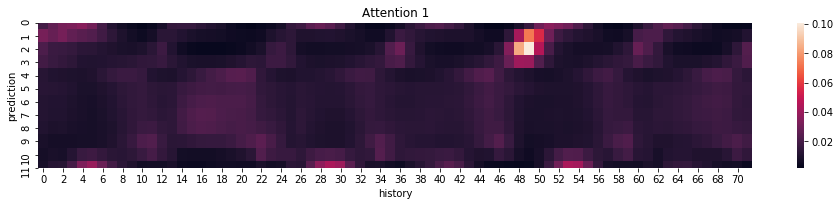

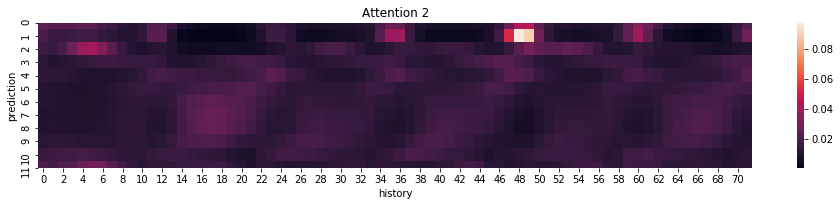

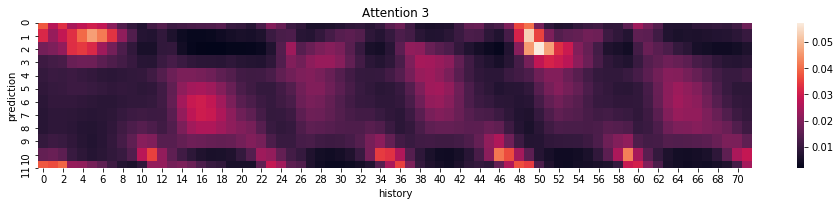

In [37]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 4 Attention prediction')

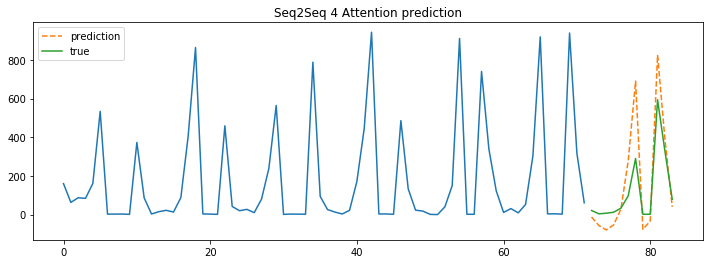

In [38]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 4 Attention prediction')

## 5. Simple WaveNet

In [6]:
dataset = SimpleWaveNetDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'dilation': [1, 2, 4, 8, 16, 32, 64],
        'dropout': 0.2,
        'residual_channels': 72,
        'teacher_forcing_rate': 0.5,
        'use_move_scale': True,
    }

compile_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
    'loss_fn': 'MSELoss',
}

In [8]:
model = SimpleWaveNet(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.944: 100%|██████████| 17/17 [00:01<00:00,  9.32it/s]


epoch 1 / 50: train loss 1.068 val loss 1.187 RMSE 180.704
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.737: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


epoch 2 / 50: train loss 0.913 val loss 1.026 RMSE 169.131


batch 17 / 17, loss 0.653: 100%|██████████| 17/17 [00:01<00:00,  9.48it/s]


epoch 3 / 50: train loss 0.785 val loss 0.875 RMSE 156.222


batch 17 / 17, loss 0.619: 100%|██████████| 17/17 [00:01<00:00,  9.97it/s]


epoch 4 / 50: train loss 0.729 val loss 0.850 RMSE 153.565


batch 17 / 17, loss 0.654: 100%|██████████| 17/17 [00:01<00:00,  9.46it/s]


epoch 5 / 50: train loss 0.720 val loss 0.848 RMSE 153.178


batch 17 / 17, loss 0.742: 100%|██████████| 17/17 [00:01<00:00,  9.70it/s]


epoch 6 / 50: train loss 0.689 val loss 0.837 RMSE 151.413


batch 17 / 17, loss 0.713: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


epoch 7 / 50: train loss 0.615 val loss 0.749 RMSE 142.762


batch 17 / 17, loss 0.609: 100%|██████████| 17/17 [00:01<00:00,  9.59it/s]


epoch 8 / 50: train loss 0.558 val loss 0.746 RMSE 141.891


batch 17 / 17, loss 0.455: 100%|██████████| 17/17 [00:01<00:00,  9.56it/s]


epoch 9 / 50: train loss 0.505 val loss 0.712 RMSE 138.075


batch 17 / 17, loss 0.427: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 10 / 50: train loss 0.456 val loss 0.687 RMSE 134.442


batch 17 / 17, loss 0.318: 100%|██████████| 17/17 [00:01<00:00,  9.72it/s]


epoch 11 / 50: train loss 0.414 val loss 0.677 RMSE 131.931


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 12 / 50: train loss 0.386 val loss 0.651 RMSE 130.122


batch 17 / 17, loss 0.345: 100%|██████████| 17/17 [00:01<00:00,  9.61it/s]


epoch 13 / 50: train loss 0.352 val loss 0.604 RMSE 120.750


batch 17 / 17, loss 0.304: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


epoch 14 / 50: train loss 0.326 val loss 0.560 RMSE 116.753


batch 17 / 17, loss 0.228: 100%|██████████| 17/17 [00:01<00:00,  9.81it/s]


epoch 15 / 50: train loss 0.301 val loss 0.536 RMSE 111.938


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:01<00:00,  9.55it/s]


epoch 16 / 50: train loss 0.291 val loss 0.504 RMSE 107.678


batch 17 / 17, loss 0.262: 100%|██████████| 17/17 [00:01<00:00,  9.53it/s]


epoch 17 / 50: train loss 0.279 val loss 0.486 RMSE 106.031


batch 17 / 17, loss 0.235: 100%|██████████| 17/17 [00:01<00:00,  9.47it/s]


epoch 18 / 50: train loss 0.259 val loss 0.435 RMSE 98.015


batch 17 / 17, loss 0.206: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 19 / 50: train loss 0.252 val loss 0.438 RMSE 97.462


batch 17 / 17, loss 0.380: 100%|██████████| 17/17 [00:01<00:00,  9.54it/s]


epoch 20 / 50: train loss 0.248 val loss 0.438 RMSE 97.261


batch 17 / 17, loss 0.202: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


epoch 21 / 50: train loss 0.234 val loss 0.388 RMSE 89.605


batch 17 / 17, loss 0.222: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 22 / 50: train loss 0.224 val loss 0.402 RMSE 92.663


batch 17 / 17, loss 0.161: 100%|██████████| 17/17 [00:01<00:00,  9.45it/s]


epoch 23 / 50: train loss 0.222 val loss 0.384 RMSE 88.312


batch 17 / 17, loss 0.148: 100%|██████████| 17/17 [00:01<00:00,  9.62it/s]


epoch 24 / 50: train loss 0.213 val loss 0.371 RMSE 86.307


batch 17 / 17, loss 0.159: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]


epoch 25 / 50: train loss 0.215 val loss 0.354 RMSE 85.687


batch 17 / 17, loss 0.193: 100%|██████████| 17/17 [00:01<00:00,  9.75it/s]


epoch 26 / 50: train loss 0.209 val loss 0.351 RMSE 83.648


batch 17 / 17, loss 0.185: 100%|██████████| 17/17 [00:01<00:00,  9.60it/s]


epoch 27 / 50: train loss 0.200 val loss 0.329 RMSE 80.128


batch 17 / 17, loss 0.178: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


epoch 28 / 50: train loss 0.207 val loss 0.327 RMSE 80.740


batch 17 / 17, loss 0.210: 100%|██████████| 17/17 [00:01<00:00,  9.65it/s]


epoch 29 / 50: train loss 0.199 val loss 0.302 RMSE 78.812


batch 17 / 17, loss 0.184: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


epoch 30 / 50: train loss 0.196 val loss 0.324 RMSE 81.929


batch 17 / 17, loss 0.279: 100%|██████████| 17/17 [00:01<00:00,  9.87it/s]


epoch 31 / 50: train loss 0.197 val loss 0.292 RMSE 78.894


batch 17 / 17, loss 0.192: 100%|██████████| 17/17 [00:01<00:00,  9.66it/s]


epoch 32 / 50: train loss 0.194 val loss 0.290 RMSE 77.234


batch 17 / 17, loss 0.210: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


epoch 33 / 50: train loss 0.193 val loss 0.311 RMSE 81.627


batch 17 / 17, loss 0.179: 100%|██████████| 17/17 [00:01<00:00,  9.60it/s]


epoch 34 / 50: train loss 0.185 val loss 0.281 RMSE 75.366


batch 17 / 17, loss 0.190: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]


epoch 35 / 50: train loss 0.188 val loss 0.271 RMSE 73.677


batch 17 / 17, loss 0.153: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 36 / 50: train loss 0.175 val loss 0.260 RMSE 73.120


batch 17 / 17, loss 0.211: 100%|██████████| 17/17 [00:01<00:00,  9.88it/s]


epoch 37 / 50: train loss 0.182 val loss 0.270 RMSE 73.501


batch 17 / 17, loss 0.189: 100%|██████████| 17/17 [00:01<00:00,  9.89it/s]


epoch 38 / 50: train loss 0.180 val loss 0.249 RMSE 71.581


batch 17 / 17, loss 0.202: 100%|██████████| 17/17 [00:01<00:00,  9.69it/s]


epoch 39 / 50: train loss 0.177 val loss 0.259 RMSE 72.289


batch 17 / 17, loss 0.240: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 40 / 50: train loss 0.182 val loss 0.264 RMSE 72.682


batch 17 / 17, loss 0.178: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


epoch 41 / 50: train loss 0.179 val loss 0.251 RMSE 72.006


batch 17 / 17, loss 0.176: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


epoch 42 / 50: train loss 0.180 val loss 0.249 RMSE 71.054


batch 17 / 17, loss 0.169: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


epoch 43 / 50: train loss 0.172 val loss 0.250 RMSE 71.930


batch 17 / 17, loss 0.159: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 44 / 50: train loss 0.177 val loss 0.250 RMSE 72.189


batch 17 / 17, loss 0.295: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


epoch 45 / 50: train loss 0.181 val loss 0.244 RMSE 69.828


batch 17 / 17, loss 0.164: 100%|██████████| 17/17 [00:01<00:00,  9.21it/s]


epoch 46 / 50: train loss 0.173 val loss 0.245 RMSE 70.611


batch 17 / 17, loss 0.146: 100%|██████████| 17/17 [00:01<00:00,  9.75it/s]


epoch 47 / 50: train loss 0.172 val loss 0.240 RMSE 69.719


batch 17 / 17, loss 0.155: 100%|██████████| 17/17 [00:01<00:00,  9.29it/s]


epoch 48 / 50: train loss 0.173 val loss 0.238 RMSE 69.436


batch 17 / 17, loss 0.126: 100%|██████████| 17/17 [00:01<00:00,  9.59it/s]


epoch 49 / 50: train loss 0.170 val loss 0.235 RMSE 69.052


batch 17 / 17, loss 0.167: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


epoch 50 / 50: train loss 0.176 val loss 0.235 RMSE 68.951
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleWaveNet_epoch_49_0.235.pkl


In [9]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f} '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f} '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f} '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.093 valid loss: 0.235 test loss :0.353 test RMSE :84.691, 


In [10]:
val_set[0].keys()

dict_keys(['enc_inputs', 'dec_outputs'])

Text(0.5, 1.0, 'Simple WaveNet prediction')

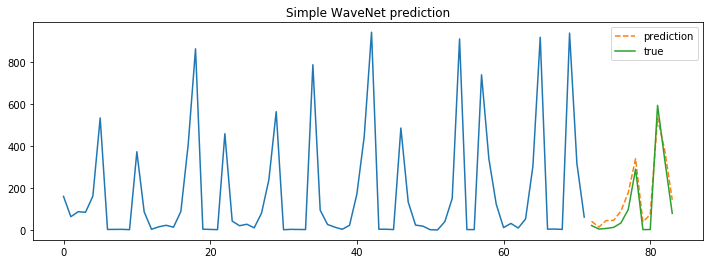

In [22]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[1]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[h], pred[h], dec_outputs[h])
plt.title('Simple WaveNet prediction')

## 6. Summary

| model | num of attention | RMSE(test) | loss(test) | loss(val) | loss(train)|
|:-:| :-: | :-:| :-:| :-:| :-:|
| SimpleSeq2Seq | / | 141.54 | 0.725|0.682|0.476|
| Seq2Seq| 0| 120.7| 0.571| 0.491| 0.279|
| Seq2Seq| 1| 113.9| 0.532| 0.427| 0.222|
| Seq2Seq| 4| 111.7 | 0.534| 0.422| 0.192|
| SimpleWaveNet| / | 84.5 | 0.355 | 0.237| 0.093|